In [116]:
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import pandas as pd
import numpy as np
import sys
import io
import math
import re
import seaborn as sns
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from collections import *
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
# from mixedmodels import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import math
import scipy
from scikits import bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore')

In [175]:
def awesome_plot(big_df, x, y, hue, col=None, smoothing=1, n_samples=10000, xlabel='', ylabel='', relabeling=None, colors=None):

    def my_bootstrap(x):
        try:
            # print bootstrap.ci(data=x, statfunction=scipy.mean, n_samples=n_samples)
            return bootstrap.ci(data=x, statfunction=scipy.mean, n_samples=n_samples)
        except BaseException as e: 
            print repr(e)
            m = scipy.mean(x)
            return (m, m)

    
    # Pre-split into different columns
    cols = [ (None, big_df)]
    if col is not None:
        cols = []
        col_names = set(big_df[col])
        for cname in col_names:
            cols.append((cname, big_df[big_df[col] == cname]))
            
    for (col_name, col_df) in cols:
    
        hues_names = set(col_df[hue])
        attr_data = []
        fig1 = plt.figure()

        for hue_name in hues_names:
            df = col_df[col_df[hue] == hue_name]

            # Get the actual mean at each year
            y1_mean = df.groupby([x], as_index=False)[y].mean()
            y1_cis = df.groupby([x], as_index=False)[y].apply(lambda x:my_bootstrap(x))
            for name, group in df.groupby([x], as_index=False):
                #print name, Counter(group[y]), my_bootstrap(group[y])
                pass
            #print ''
            #print y1_cis
            attr_data.append((y1_mean, y1_cis, hue_name))
            
        # EWM = Exponentially-Weighted Mean, which is what we use for smooth.  Set this to 1 for no smoothing
        ewm_span = smoothing

        # Get the upper and lower bound for the confidence intervals
        for j, (attr_mean, attr_cis, attr_name) in enumerate(attr_data):
            EwmAcc = attr_mean[y].ewm(span=ewm_span).mean()
            
            upper_bound = []
            lower_bound = []
            eb_df_data = {'Upper Bound': upper_bound, 'Lower Bound': lower_bound}
    
            for i in range(0, len(attr_cis)):
                lower_bound.append(attr_cis[i][0])
                upper_bound.append(attr_cis[i][1])

            eb_df = pd.DataFrame(eb_df_data, columns = ['Upper Bound', 'Lower Bound'])
            attr_mean['Ewm Mean'] = EwmAcc
            attr_mean['Ewm UB'] = eb_df['Upper Bound'].ewm(span=ewm_span).mean()
            attr_mean['Ewm LB'] = eb_df['Lower Bound'].ewm(span=ewm_span).mean()
            
            # print attr_mean.head(100)
            
        mycolors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']        
        if colors is None:
            colors = mycolors
        styles = ['-', '--', '-.', ':', '-']
        for j, (attr_mean, attr_cis, attr_name) in enumerate(attr_data):
            # print col_name, attr_name
 
            label = attr_name
            if relabeling is not None:
                if label in relabeling:
                    label = relabeling[label]

            plt.plot(attr_mean[x], attr_mean['Ewm Mean'], \
                     label=label, color=colors[j % len(colors)], ls=styles[j % len(styles)])
        
            # print attr_mean[x], attr_mean['Ewm LB'], attr_mean['Ewm UB']
            plt.fill_between(attr_mean[x], attr_mean['Ewm LB'], attr_mean['Ewm UB'], \
                             interpolate=False, alpha=0.1, edgecolor=None, \
                             color=colors[j % len(colors)])
    
        plt.legend(ncol=1, fontsize=14, loc='upper left', bbox_to_anchor=(1., 0.8))
        plt.gca().set_axis_bgcolor('white')
        if col_name is not None:
            plt.suptitle(col + ' = ' + str(col_name))


        ax = plt.gca()
        # 'Reproductive Success Rate\n(what % of graduates have children)'
        ax.set_ylabel(ylabel, fontsize=22)
        ax.set_xlabel(xlabel, fontsize=22)  
        ax.grid(False)
        plt.tight_layout()   

In [172]:
def percent_sample_awesome_plot(big_df, x, y, hue, col=None, smoothing=1, n_samples=10000, xlabel='', ylabel='', relabeling=None, colors=None):
    hues = set(big_df[hue])

    grouped = big_df.groupby(x)
    df_for_plot = []
    for x_val, group in grouped:
        raw_counts = []
        # print x_val, group[[hue, y]]
        for row in group[[hue, y]].itertuples():
            hue_name = row[1]
            # Generate a long list of how many times this particular hue occurred
            for i in range(row[2]):
                raw_counts.append(hue_name)

        # Sample from the total counts to bootstrap the percentages of how many times each hue occurs
        n = len(raw_counts)
        nf = float(n)
        hue_to_probs = defaultdict(list)
        for i in range(n_samples):
            sample = np.random.choice(raw_counts, n)
            counts = Counter(sample)
            for h in hues:
                hue_to_probs[h].append(counts[h] / nf)
        
        # print hue_to_probs
        for h, probs in hue_to_probs.iteritems():
            bleh = {}
            df_for_plot.append(bleh)

            probs.sort()
            bleh['X'] = x_val
            bleh['Hue'] = h
            bleh['Mean'] = probs[len(probs)/2]
            bleh['Upper Bound'] = probs[(19*len(probs))/20] # 95%
            bleh['Lower Bound'] = probs[len(probs)/20]  # 5%
    df_for_plot = pd.DataFrame(df_for_plot)
    
    mycolors = [ 
              
                  '#66a61e',
   
           '#e7298a',        
               '#7570b3',
             '#1b9e77',

          '#e6ab02',
                       '#d95f02',

    ] 
    
    if colors is None:
        colors = mycolors
    
    styles = ['-', '--', '-.', ':', '-']
    for j, h in enumerate(hues):
        sub_df = df_for_plot[df_for_plot['Hue'] == h]
        xs = sub_df['X']

        attr_mean = sub_df['Mean']
        
        #print h, attr_mean
        
        lower_bound = sub_df['Lower Bound']
        upper_bound = sub_df['Upper Bound']

        label = h
        if relabeling is not None:
            if label in relabeling:
                label = relabeling[label]

        plt.plot(xs, attr_mean, \
                label=label, color=colors[j % len(colors)], ls=styles[j % len(styles)])
        
        plt.fill_between(xs, lower_bound, upper_bound, \
                         interpolate=False, alpha=0.1, edgecolor=None, \
                         color=colors[j % len(colors)])
    
    plt.legend(ncol=1, fontsize=24, loc='upper left', bbox_to_anchor=(1., 0.8))
    plt.gca().set_axis_bgcolor('white')

    ax = plt.gca()
    ax.set_ylabel(ylabel, fontsize=22)
    ax.set_xlabel(xlabel, fontsize=22)  
    ax.grid(False)
    plt.tight_layout()   

In [18]:
#year_to_func_counts = defaultdict(Counter)
year_to_func_counts_df = []
functions = set()
#with open('../results/citation-graph/custom-weights4/cite-func.all.tsv') as f:    
with open('../results/citation-graph/custom-weights6/cite-func.all.tsv') as f:

    for line in f: 
        cols = line[:-1].split('\t')
        year = int(cols[0][1:3])
        if year < 50:
            year += 2000
        else:
            year += 1900
        function = cols[4]
        #year_to_func_counts[year][function] += 1
        year_to_func_counts_df.append({'year': year, 'function': function, 'count':1 })
        functions.add(function)
        
year_to_func_counts_df = pd.DataFrame(year_to_func_counts_df)

In [19]:
#year_to_func_counts_df.head()
after_1980_df = year_to_func_counts_df[year_to_func_counts_df['year'] >= 1980]

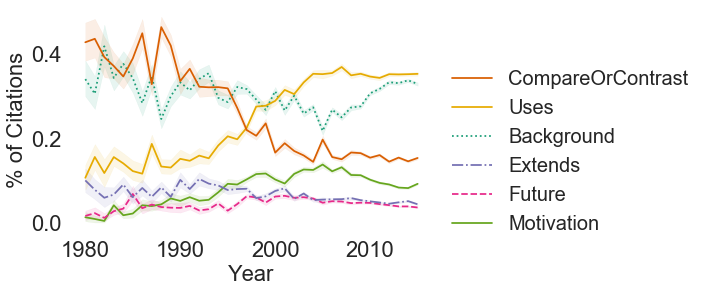

In [155]:
g = percent_sample_awesome_plot(after_1980_df, x='year', y='count', 
                            hue='function', n_samples=1000, xlabel='Year', 
                            ylabel='% of Citations')
plt.gca().tick_params(labelsize=22)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(reversed(handles), reversed(labels), loc='upper left', 
               ncol=1, fontsize=20, bbox_to_anchor=(1., 0.8))

plt.savefig('cr_trends.mean.2.pdf', bbox_inches='tight')

In [157]:
typed_year_to_cited_counts = defaultdict(lambda: defaultdict(Counter))

func_year_to_cited = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))

with open('../results/citation-graph/custom-weights6/cite-func.all.tsv') as f:

    for line in f: 
        cols = line[:-1].split('\t')
        year = int(cols[0][1:3])
        if year < 50:
            year += 2000
        else:
            year += 1900
        function = cols[4]
        
        if not (function == 'CompareOrContrast' or function == 'Uses'):
            continue

        cited = cols[1]
            
        typed_year_to_cited_counts[function][year][cited] += 1
        func_year_to_cited[function][year][cited].add(cols[0])

In [32]:
cite_df = []
for func, bleh in typed_year_to_cited_counts.iteritems():
    for year, cited_counts in bleh.iteritems():
        for p, c in cited_counts.iteritems():
            cite_df.append({'year': year, 'paper': p, 'cites': c, 'hue': 'dummy'})
cite_df = pd.DataFrame(cite_df)

In [164]:
cite_df = []
for func, whatever in func_year_to_cited.iteritems():
    for year, bleh in whatever.iteritems():
        for cited, citing in bleh.iteritems():
            if len(citing) > 4 and year < 1999:
                print cited, year, len(citing)
            cite_df.append({'year': year, 'cites': len(citing), 'hue': func})
cite_df = pd.DataFrame(cite_df)

External_692 1997 5
External_3896 1997 7
External_32929 1997 8
External_5199 1997 6
External_3395 1997 5
External_5854 1997 5
External_4040 1997 7
External_336 1997 7
External_2488 1997 6
External_4611 1997 6
External_502 1997 7
External_502 1998 5
External_681 1998 8
External_32929 1998 6
External_482 1998 6
External_3257 1998 10
External_3692 1998 5
External_1025 1998 6
External_1497 1988 5
External_19373 1997 6
External_6640 1997 6
External_3565 1998 5
External_2488 1998 5


In [165]:
cite_df.tail()
print Counter(cite_df['hue'])

Counter({'Uses': 57786, 'CompareOrContrast': 33512})


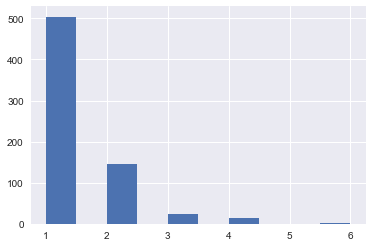

In [110]:
cite_df[cite_df['year'] == 1997]['cites'].hist(log=False)

In [68]:
df = cite_df[['year', 'cites']].groupby(['year']).var()
df2 = df.reset_index()
# df2.head(30)


In [167]:
cite_df = cite_df[cite_df['year'] >= 1980]

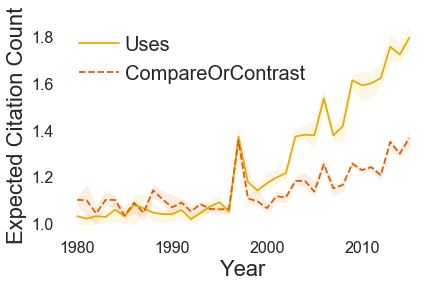

In [178]:
colors = [              
#                  '#66a61e',   
#           '#e7298a',        
#               '#7570b3',
#             '#1b9e77',
#
          '#e6ab02',
                       '#d95f02',

    ] 

g = awesome_plot(cite_df, x='year', y='cites', hue='hue',  
                 n_samples=10, smoothing=1, xlabel='Year', 
                 ylabel='Expected Citation Count', colors=colors)
plt.gca().legend().remove() #sns.lmplot(data=cite_df, x='year', y='cites', order=2, scatter=False)
plt.gca().tick_params(labelsize=16)
plt.legend(loc='best', handletextpad=0.3, fontsize=20,)
plt.savefig('cc_trends.3.pdf', bbox_inches='tight')

#for tick in plt.gca().get_major_ticks():
#    tick.label.set_fontsize(16) 